In [9]:
#Importar modulo de lectura de pypdf
from PyPDF2 import PdfFileReader

import re, string, unicodedata
# NLTK
# kit de herramientas de lenguaje natural
import nltk #https://www.nltk.org/

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords

# INFLECT
#para realizar las tareas relacionadas con el lenguaje natural de generar plurales, 
#sustantivos singulares, ordinales y artículos indefinidos, y 
#(lo que más nos interesa) convertir números en palabras
import inflect #https://pypi.org/project/inflect/

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import operator

import numpy as np

[nltk_data] Downloading package punkt to /home/magdalena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magdalena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/magdalena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Vamos a leer pdf con el discurso de los 6 candidatos
discurso_6_candidatos = PdfFileReader(open("datos/Version-taquigrafica.pdf", "rb"))

In [3]:
#Capturar la cantidad de paginas que tiene el documento
paginas = discurso_6_candidatos.getNumPages()
print('Cantidad de páginas:',paginas)

Cantidad de páginas: 35


In [4]:
texto_discurso_6 = ""
for i in range(paginas):
    pagina_i = discurso_6_candidatos.getPage(i)
    texto_i = pagina_i.extractText()
    texto_discurso_6 = texto_discurso_6 + ' ' + texto_i.replace('\n',"")

In [5]:
diccionario = dict()
lista_discurso = texto_discurso_6.split()
iteraciones = len(lista_discurso)

for t in range(iteraciones):
    #print(t,lista_discurso[t])
    if lista_discurso[t] == 'Sr.' or lista_discurso[t] == 'Sra.':#Empieza a hablar
        #print(lista_discurso[t],lista_discurso[t+1])
        aux = t + 1
        #print(aux,lista_discurso[aux])
        if '.-' in lista_discurso[aux]:
            candidato = lista_discurso[aux].replace('.-',"")
            aux += 1
        else:
            candidato = lista_discurso[aux] + ' ' + lista_discurso[aux+1].replace('.-',"")
            aux+=2
        if not candidato in diccionario:
            diccionario[candidato] = ""
        while lista_discurso[aux] != 'Sr.' and lista_discurso[aux] != 'Sra.' and aux < iteraciones -1:#Empieza a hablar otro
            try:
                diccionario[candidato] = diccionario[candidato] + " " + lista_discurso[aux]
                aux += 1
            except:
                pass
        t = aux
        
#Quito lo que dicen los conductores        
del diccionario['Barili']
del diccionario['Bonelli']
del diccionario['Novaresio']

In [6]:
for i in diccionario:
    print('Cantidad de palabras dichas por',i,': ',len(diccionario[i]),'\n')

Cantidad de palabras dichas por Macri :  15395 

Cantidad de palabras dichas por Stolbizer :  16349 

Cantidad de palabras dichas por Massa :  13565 

Cantidad de palabras dichas por Del Caño :  14534 

Cantidad de palabras dichas por Rodríguez Saá :  10393 



In [7]:
#Normalización
#poner todo el texto en igualdad de condiciones: convirtiendo todo el texto en el 
#mismo caso (superior o inferior), eliminando la puntuación, convirtiendo los números 
#a sus equivalentes de palabras, y así sucesivamente

def remove_non_ascii(words):
    """Eliminar caracteres no ASCII de la lista de palabras en token"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convierte todos los caracteres a minúsculas de la lista de palabras tokenizadas"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Eliminar puntuación de la lista de palabras tokenizadas"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplace todas las apariciones de enteros en la lista de palabras tokenizadas con representación textual"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Eliminar palabras de parada de la lista de palabras en token"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas

#Las palabras clave se consideran como ruido en el texto. Las eliminamos
stop_words=set(stopwords.words("spanish"))

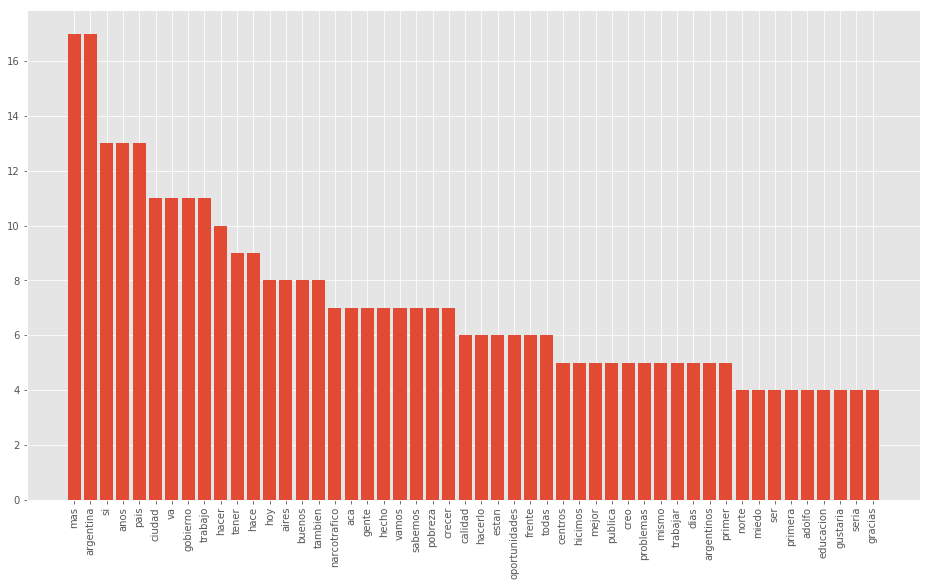

In [10]:
#ANÁLISIS MACRI
#Tokenización
#divide cadenas de texto más largas en piezas más pequeñas o tokens 
palabras_macri = nltk.word_tokenize(diccionario['Macri'])
#print(palabras_macri)

palabras_macri = normalize(palabras_macri)
#print(palabras_macri)

#Quitamos palabras ruido
palabras_macri_filtradas=[]
for w in palabras_macri:
    if w not in stop_words:
        palabras_macri_filtradas.append(w)

#Frecuencia de distribución
fdist_macri = FreqDist(palabras_macri_filtradas)

# Ploteo 50 palabras más usadas
#fdist_macri.plot(50,cumulative=False)
#plt.show()

#for i in fdist_macri:
    #if fdist_macri[i]
#    print(i,fdist_macri[i])
resultado = sorted(fdist_macri.items(), key=operator.itemgetter(1))
resultado.reverse()
#print(resultado[:50])

x = np.arange(50)
plt.bar(x, [i[1] for i in resultado[:50]])
plt.xticks(x, (i[0] for i in resultado[:50]),rotation='vertical')
plt.show()

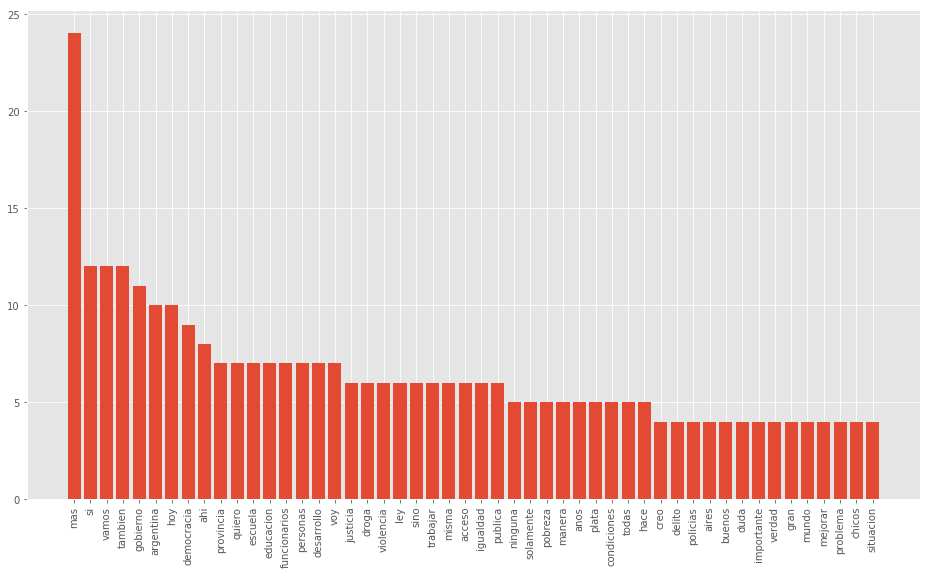

In [11]:
#ANÁLISIS STOLBIZER
#Tokenización
#divide cadenas de texto más largas en piezas más pequeñas o tokens 
palabras_stolbizer = nltk.word_tokenize(diccionario['Stolbizer'])
#print(palabras_stolbizer)

palabras_stolbizer = normalize(palabras_stolbizer)
#print(palabras_stolbizer)

#Quitamos palabras ruido
palabras_stolbizer_filtradas=[]
for w in palabras_stolbizer:
    if w not in stop_words:
        palabras_stolbizer_filtradas.append(w)

#Frecuencia de distribución
fdist_stolbizer = FreqDist(palabras_stolbizer_filtradas)

# Ploteo 50 palabras más usadas
#fdist_stolbizer.plot(50,cumulative=False)
#plt.show()

resultado = sorted(fdist_stolbizer.items(), key=operator.itemgetter(1))
resultado.reverse()
#print(resultado[:50])

x = np.arange(50)
plt.bar(x, [i[1] for i in resultado[:50]])
plt.xticks(x, (i[0] for i in resultado[:50]),rotation='vertical')
plt.show()

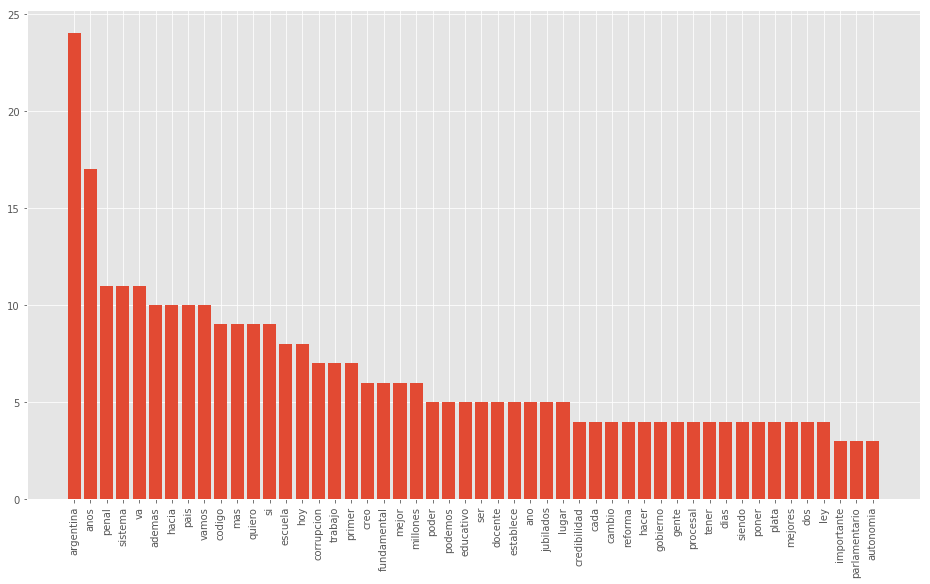

In [12]:
#ANÁLISIS MASSA
#Tokenización
#divide cadenas de texto más largas en piezas más pequeñas o tokens 
palabras_massa = nltk.word_tokenize(diccionario['Massa'])
#print(palabras_massa)

palabras_massa = normalize(palabras_massa)
#print(palabras_massa)

#Quitamos palabras ruido
palabras_massa_filtradas=[]
for w in palabras_massa:
    if w not in stop_words:
        palabras_massa_filtradas.append(w)

#Frecuencia de distribución
fdist_massa = FreqDist(palabras_massa_filtradas)

# Ploteo 50 palabras más usadas
#fdist_massa.plot(50,cumulative=False)
#plt.show()

resultado = sorted(fdist_massa.items(), key=operator.itemgetter(1))
resultado.reverse()
#print(resultado[:50])

x = np.arange(50)
plt.bar(x, [i[1] for i in resultado[:50]])
plt.xticks(x, (i[0] for i in resultado[:50]),rotation='vertical')
plt.show()

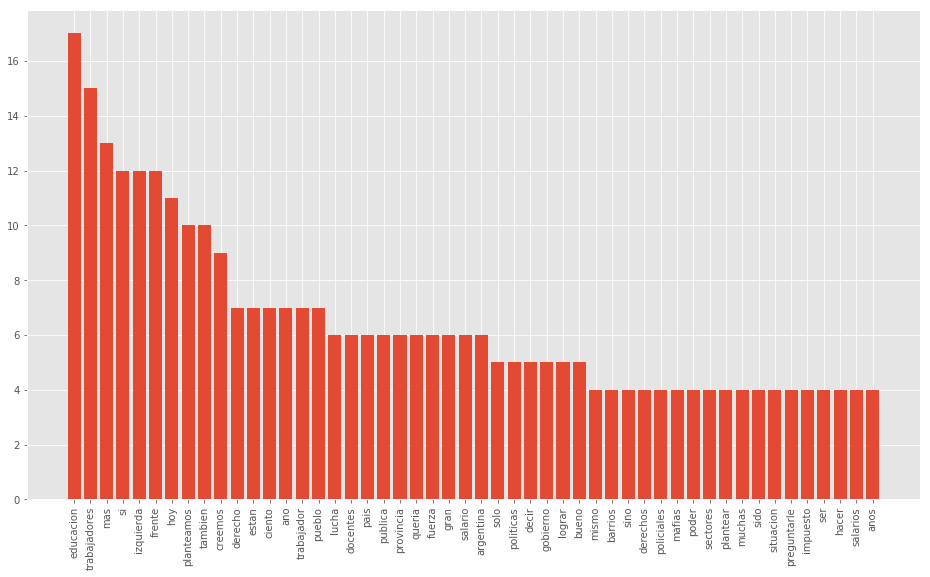

In [13]:
#ANÁLISIS DEL CAÑO
#Tokenización
#divide cadenas de texto más largas en piezas más pequeñas o tokens 
palabras_delcano = nltk.word_tokenize(diccionario['Del Caño'])
#print(palabras_delcano)

palabras_delcano = normalize(palabras_delcano)
#print(palabras_delcano)

#Quitamos palabras ruido
palabras_delcano_filtradas=[]
for w in palabras_delcano:
    if w not in stop_words:
        palabras_delcano_filtradas.append(w)

#Frecuencia de distribución
fdist_delcano = FreqDist(palabras_delcano_filtradas)

# Ploteo 50 palabras más usadas
#fdist_delcano.plot(50,cumulative=False)
#plt.show()

resultado = sorted(fdist_delcano.items(), key=operator.itemgetter(1))
resultado.reverse()
#print(resultado[:50])

x = np.arange(50)
plt.bar(x, [i[1] for i in resultado[:50]])
plt.xticks(x, (i[0] for i in resultado[:50]),rotation='vertical')
plt.show()

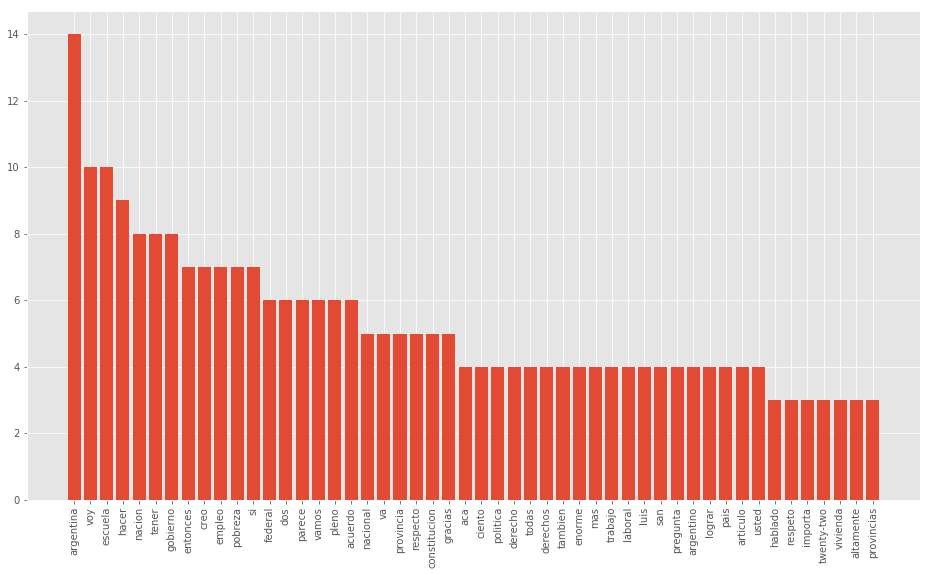

In [14]:
#ANÁLISIS RODRIGUEZ SAÁ
#Tokenización
#divide cadenas de texto más largas en piezas más pequeñas o tokens 
palabras_rodriguezsaa = nltk.word_tokenize(diccionario['Rodríguez Saá'])
#print(palabras_rodriguezsaa)

palabras_rodriguezsaa = normalize(palabras_rodriguezsaa)
#print(palabras_rodriguezsaa)

#Quitamos palabras ruido
palabras_rodriguezsaa_filtradas=[]
for w in palabras_rodriguezsaa:
    if w not in stop_words:
        palabras_rodriguezsaa_filtradas.append(w)

#Frecuencia de distribución
fdist_rodriguezsaa = FreqDist(palabras_rodriguezsaa_filtradas)

# Ploteo 50 palabras más usadas
#fdist_rodriguezsaa.plot(50,cumulative=False)
#plt.show()

resultado = sorted(fdist_rodriguezsaa.items(), key=operator.itemgetter(1))
resultado.reverse()
#print(resultado[:50])

x = np.arange(50)
plt.bar(x, [i[1] for i in resultado[:50]])
plt.xticks(x, (i[0] for i in resultado[:50]),rotation='vertical')
plt.show()

In [15]:
print(fdist_macri.unicode_repr())
print(fdist_stolbizer.unicode_repr())
print(fdist_massa.unicode_repr())
print(fdist_delcano.unicode_repr())
print(fdist_rodriguezsaa.unicode_repr())

FreqDist({'argentina': 17, 'mas': 17, 'pais': 13, 'anos': 13, 'si': 13, 'trabajo': 11, 'gobierno': 11, 'va': 11, 'ciudad': 11, 'hacer': 10, ...})
FreqDist({'mas': 24, 'tambien': 12, 'vamos': 12, 'si': 12, 'gobierno': 11, 'hoy': 10, 'argentina': 10, 'democracia': 9, 'ahi': 8, 'voy': 7, ...})
FreqDist({'argentina': 24, 'anos': 17, 'va': 11, 'sistema': 11, 'penal': 11, 'vamos': 10, 'pais': 10, 'hacia': 10, 'ademas': 10, 'si': 9, ...})
FreqDist({'educacion': 17, 'trabajadores': 15, 'mas': 13, 'frente': 12, 'izquierda': 12, 'si': 12, 'hoy': 11, 'tambien': 10, 'planteamos': 10, 'creemos': 9, ...})
FreqDist({'argentina': 14, 'escuela': 10, 'voy': 10, 'hacer': 9, 'gobierno': 8, 'tener': 8, 'nacion': 8, 'si': 7, 'pobreza': 7, 'empleo': 7, ...})
